### Libraries

In [132]:
%matplotlib inline
import numpy as np
import os
from glob import glob
# import cv2
import skimage.io as skio
import matplotlib.pyplot as plt
import torch
# from sklearn.feature_extraction import image

### Load data

In [40]:
refDir = r'/media/banikr2/DATA/Diesel_block/4_refocus'
segDir = r'/media/banikr2/DATA/Diesel_block/5_segmented'
mskDir = r'/media/banikr2/DATA/Diesel_block/6_binarymask'
refFiles = sorted(glob(os.path.join(refDir, '*.tif')))#.sort()
segFiles = sorted(glob(os.path.join(segDir, '*.tif')))#.sort()
mskFiles = sorted(glob(os.path.join(mskDir, '*.png')))

Same number of image slices:

In [42]:
len(refFiles), len(segFiles), len(mskFiles)

(294, 294, 294)

In [43]:
# im = cv2.imread(refFiles[0], -1)
im = skio.imread(refFiles[20], plugin="tifffile")
sg = skio.imread(segFiles[20], plugin="tifffile")
mk = skio.imread(mskFiles[20])

In [11]:
im.dtype, im.shape, sg.dtype, sg.shape

(dtype('uint8'), (900, 900, 3), dtype('uint8'), (900, 900, 3))

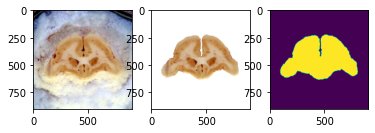

In [47]:
plt.subplot(131)
plt.imshow(im)
# plt.axis("off")
plt.subplot(132)
plt.imshow(sg)
# plt.axis("off")
plt.subplot(133)
plt.imshow(mk)
plt.show()

``` matlab
>> whos img21
  Name         Size                 Bytes  Class    Attributes

  img21      900x900x3            2430000  uint8  

>> whos seg21
  Name        Size                 Bytes  Class    Attributes
  seg21      900x900x3            2430000  uint8              
```

ground truth should be converted to a binary mask?<br> $0$ --> non-brain part of the slice <br> $1$ --> brain part of the slice

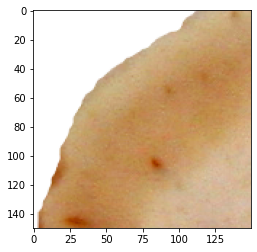

In [12]:
sg_chunk = sg[250:400,200:350,:]
plt.imshow(sg_chunk)

Convert to grayscale `rgb2gray` in *Matlab*

|<p>|<p>|<p>|<p>|
|:-:|:-:|:-:|:-:|
| <img src="../Images/rgb_21.jpg" style="width: 200px;"/> _slice #020_ |<img src="../Images/seg_21.jpg" style="width: 200px;"/> |<img src="../Images/grayscale_21.jpg" style="width: 200px;"/> |<img src="../Images/binarymask_21.jpg" style="width: 200px;"/>  |
| <img src="../Images/rgb_201.jpg" style="width: 200px;"/> _slice #200_|<img src="../Images/seg_201.jpg" style="width: 200px;"/>|<img src="../Images/grayscale_201.jpg" style="width: 200px;"/> |<img src="../Images/binarymask_201.jpg" style="width: 200px;"/>  |
|_refocused image(RGB)_|_segmented image(RGB)_|_grayscaled_|_binary mask_|

non-brain pixels were removed by `regionprops` Matlab

|<p>|<p>|
|:-:|:-:|
| <img src="../Images/binarymask_190.png" style="width: 200px;"/> |<img src="../Images/binarybrainmask_190.png" style="width: 200px;"/> |

patch size : `128,128,3` or `224,224,3` <br>
The following code should cover the whole image/mask given patchsize and stepsize

In [180]:
def patchify(img, msk, patchsize, step, retovermat=False, plotovermat=False):
    """ 
    img: image to patchify
    msk: binary mask to patchify
    patchsize: e.g. [100,100,3]
    step: for windown sliding e.g. [100,100]
    retovermat: return the overlap matrix, default = False
    plotovermat: visualize the patching, default = False
    """
    count=0
    imgPatch = []
    mskPatch = []
    overlapMat = np.zeros_like(img[...,0])
    for r in range(0,im.shape[0]-patchsize[0],stepsize[0]):
        for c in range(0,im.shape[1]-patchsize[1], stepsize[1]):
            count+=1
            overlapMat[r:r+patchsize[0],c:c+patchsize[1]]+=1    
            imgPatch.append(img[r:r+patchsize[0],c:c+patchsize[1],:])
            mskPatch.append(msk[r:r+patchsize[0],c:c+patchsize[1]])
            if c+stepsize[1]+patchsize[1]>im.shape[1]:
                count+=1
                overlapMat[r:r+patchsize[0],im.shape[1]-patchsize[1]:im.shape[1]]+=1
                imgPatch.append(img[r:r+patchsize[0],im.shape[1]-patchsize[1]:im.shape[1],:])
                mskPatch.append(msk[r:r+patchsize[0],im.shape[1]-patchsize[1]:im.shape[1]])
            if r+stepsize[0]+patchsize[0]>im.shape[0]:
                count+=1
                overlapMat[im.shape[0]-patchsize[0]:im.shape[0],c:c+patchsize[1]]+=1
                imgPatch.append(img[im.shape[0]-patchsize[0]:im.shape[0],c:c+patchsize[1],:])
                mskPatch.append(msk[im.shape[0]-patchsize[0]:im.shape[0],c:c+patchsize[1]])
            if r+stepsize[0]+patchsize[0]>im.shape[0] and c+stepsize[1]+patchsize[1]>im.shape[1]:
                count+=1
                overlapMat[im.shape[0]-patchsize[0]:im.shape[0],im.shape[1]-patchsize[1]:im.shape[1]]+=1
                imgPatch.append(img[im.shape[0]-patchsize[0]:im.shape[0],im.shape[1]-patchsize[1]:im.shape[1],:])
                mskPatch.append(msk[im.shape[0]-patchsize[0]:im.shape[0],im.shape[1]-patchsize[1]:im.shape[1]])
    imgPatch = np.array(imgPatch).astype(img.dtype)
    mskPatch = np.array(mskPatch).astype(msk.dtype)
    if plotovermat:
        c = plt.imshow(overlapMat)
        plt.colorbar(c)
        plt.show()
    if retovermat:
        return imgPatch, mskPatch, overlapMat
    else:
        return imgPatch, mskPatch

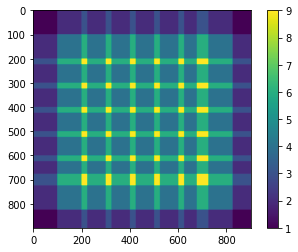

In [174]:
patchsize = [224, 224]
stepsize = [100, 100]
i, m = patchify(im,mk,patchsize,stepsize,plotovermat=True)

In [175]:
i.shape, m.shape

((64, 224, 224, 3), (64, 224, 224))

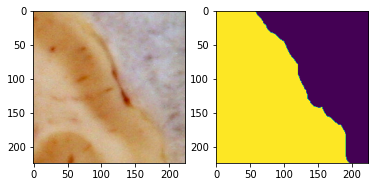

In [178]:
plt.subplot(121)
plt.imshow(i[30,...])
# plt.show()
plt.subplot(122)
plt.imshow(m[30,...])
plt.show()

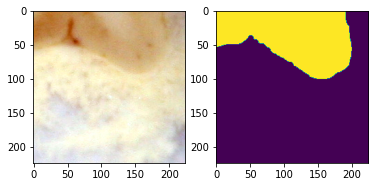

In [179]:
plt.subplot(121)
plt.imshow(i[46,...])
# plt.show()
plt.subplot(122)
plt.imshow(m[46,...])
plt.show()

In [26]:
patches = torch.tensor(sg).unfold(0, 128, 10).unfold(1, 128, 10).unfold(2, 3, 3)
print(patches.shape)

torch.Size([78, 78, 1, 128, 128, 3])


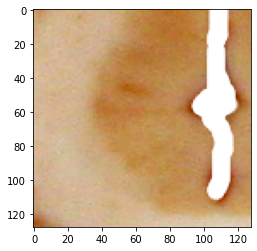

In [157]:
plt.imshow(patches[31,35,0,...])

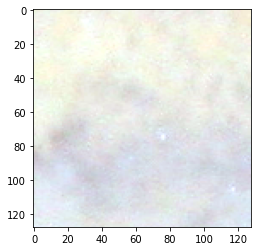

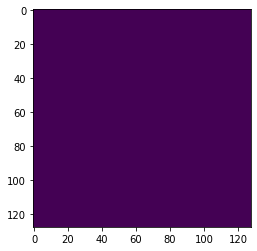

In [51]:
plt.imshow(patches_[17,...])
plt.show()
plt.imshow(mskpatches[17,...])

### ToDo:
1. ~~Remove isolated pixels outside brain.~~
2. ~~Create binary/target masks for all the slices and datastructure...~~
3. ~~Tiling for image and masks.~~
4. Dataset/DataLoader in pytorch.
5. Network architecture: start with U-Net?
6. Loss function(binary cross entropy or ?)

### Questions/doubt:
1. How to validate the created binary masks? 
2. ~~There are small pixels scattered outside brain regions, do we need to remove those by erosion or other morphological operations?~~
 - ~~**caveats:** some slices have unit brain, some have two or three parts, _largest connected component_ may not work.~~